# 1. Introduction

**Goal:** Build a small *digital synthesizer* that generates basic waveforms, shapes them with an ADSR envelope, and processes them through linear filters (LP/HP/BP and all-pass). The final deliverable is a short sound effect rendered to a `.wav` file, with figures and brief justifications along the way.

**Why this fits the course:**

* In this course, signals are modeled and analyzed as **sums of sinusoids/complex exponentials** → foundation for oscillators *(lecture 1)*. 
* Systems are treated as **LT(I)D systems** characterized by impulse response / convolution and transfer functions → foundation for filters *(lecture 2-continuous & 2-discrete)*. 
* **Sampling & aliasing** set constraints for the sampling rate and frequency content we will generate/play back *(lecture 1; hands-on “Sampling”)*.  
* **Convolution/filtering** is the practical tool we’ll use to implement LP/HP/BP and to explore all-pass phase effects *(hands-on “Convolution, filtering and simple linear systems”)*. 
* **Fourier analysis** will be used to visualize spectra of our waveforms and filtered results *(hands-on “Fourier analysis of digital signals”)*. 

**What we will build:**
1. Oscillators for sine/square/triangle/saw; 
2. an **ADSR** envelope applied by pointwise multiplication; 
3. **filters** (LP/HP/BP/BS) plus an **all-pass** (possibly in cascades); 
4. a final **sound design** combining addition/multiplication/filtering and saved as `.wav`.

**Notebook roadmap.**
* **Section 2 - Signal Generation (Oscillator)**: periodic signals, duty-cycle for square, spectrum checks *(lecture 1; hands-on Sampling & Toolbox: sinusoid)*.  
* **Section 3 - ADSR Envelope**: attack/decay/sustain/release; linear vs. exponential shaping; apply via multiplication *(LT(I)D scaling + time operations from lectures)*. 
* **Section 4 - Filtering**: implement LP/HP/BP/BS; analyze magnitude/phase; explore **all-pass** and cascades *(lecture 2; hands-on Convolution/Filtering)*.  
* **Section 5 - Sound Synthesis**: combine (add/multiply/filter/concatenate), justify parameters, export `.wav` *(hands-on Data I/O + Fourier analysis for plots)*. 

**Conventions in this notebook:**
* We’ll keep sampling at **fs ≥ 44.1 kHz** for audio examples unless otherwise stated, to avoid aliasing of upper harmonics *(lecture 1; hands-on Sampling)*.  



# 2. Signal Generation (Oscillator)

The first building block of the synthesizer is the **oscillator**, which produces basic periodic signals.
These waveforms (sinusoid, square, triangle, sawtooth) are the fundamental components from which all complex sounds can be built.
In this section, we define and visualize them, both in time and frequency domains.

---

## 2.1 Theoretical background

*(lecture 1 – Introduction to discrete-time signals and systems; hands-on “Sampling”)*  

Any periodic discrete-time signal can be expressed as a sum of sinusoids with different amplitudes, frequencies and phases — this is the **Fourier series representation**.

A sampled sinusoid is defined as:

[
x[n] = A \cdot \sin(2\pi f_0 n / f_s + \phi)
]

where

* (A): amplitude
* (f_0): frequency (Hz)
* (f_s): sampling frequency (Hz)
* (\phi): phase (radians)
* (n): sample index

To avoid **aliasing**, the sampling theorem requires (f_s > 2 f_{\text{max}}).
This ensures that no high-frequency components are folded back into the audible range.

In practice, musical instruments and synthesized sounds contain several harmonics, i.e. multiple sinusoids at integer multiples of a fundamental frequency *(lecture 2 – Spectral representation)*. 

---

## 2.2 Sinusoid generation

*(hands-on “Toolbox: Sinusoidal signal with defined amplitude, frequency and phase”)* 

To start, we implement a simple **sinusoid generator** that outputs a signal of given amplitude, frequency, phase, sampling rate and duration.



👉 **Bloc code #1 – function definition**
*(function to generate the sinusoid and return both time vector and signal)*

We then generate an example sinusoid at 440 Hz (A4 tone) and visualize it in time.



In [1]:
# --- Bloc code #1 – Sinusoid generator function ---
# This cell defines a simple sine wave generator.
# The same function exists in src/signal_generators.py,
# but we re-import it here for clarity and demonstration.

from src.signal_generators import sine_wave
from src.utils import FS, make_time
import numpy as np
import matplotlib.pyplot as plt

# Example: test the function standalone
def demo_sine_wave(freq=440, duration=1.0, amp=1.0, phase=0.0, fs=FS):
    """
    Generate and return a sine wave with given parameters.
    Also returns its corresponding time vector.
    """
    t = make_time(duration, fs)
    x = sine_wave(freq, duration, amp, phase, fs)
    return t, x

# Generate a 440 Hz sine wave for 1 second
t_demo, x_demo = demo_sine_wave(freq=440, duration=1.0, fs=FS)

# Quick check
print(f"Generated sine wave: {len(x_demo)} samples at {FS} Hz → {len(x_demo)/FS:.2f} seconds")


Generated sine wave: 44100 samples at 44100 Hz → 1.00 seconds


👉 **Bloc code #2 – example generation + time-domain plot**



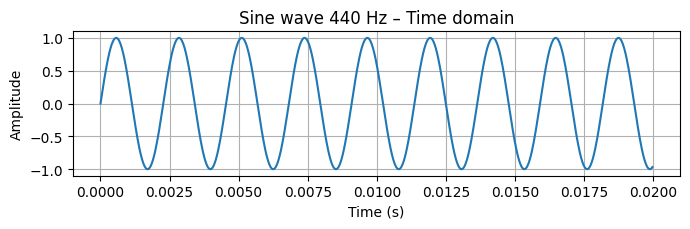

✅ Sine wave generated and saved to:
   • Audio : output/sounds/step2_sine_440Hz.wav
   • Plot  : output/plots/step2_sine_time.png


In [2]:
# --- Bloc code #2 – Example generation + time-domain plot ---

from src.signal_generators import sine_wave
from src.visualization import plot_time
from src.utils import FS, normalize_audio, save_wav
from pathlib import Path
import matplotlib.pyplot as plt

# Parameters
freq = 440.0       # Frequency in Hz (A4 tone)
duration = 1.0     # seconds
amplitude = 1.0

# Generate sine wave
x = sine_wave(freq, duration=duration, amp=amplitude, fs=FS)

# Create output folders
Path("output/sounds").mkdir(parents=True, exist_ok=True)
Path("output/plots").mkdir(parents=True, exist_ok=True)

# --- Plot time-domain waveform (first 20 ms) ---
plt.figure(figsize=(7, 2.4))
N = int(0.02 * FS)  # 20 ms
t = (1 / FS) * np.arange(N)
plt.plot(t, x[:N])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Sine wave {freq:.0f} Hz – Time domain")
plt.grid(True)
plt.tight_layout()

# Save plot
plot_path = "output/plots/step2_sine_time.png"
plt.savefig(plot_path, dpi=300)
plt.show()

# --- Normalize and save audio file ---
save_wav("output/sounds/step2_sine_440Hz.wav", normalize_audio(x), FS)

print(f"✅ Sine wave generated and saved to:")
print(f"   • Audio : output/sounds/step2_sine_440Hz.wav")
print(f"   • Plot  : {plot_path}")



## 2.3 Spectral visualization

*(hands-on “Sampling” + “Fourier analysis of digital signals”)* 

The **Fourier Transform** of a sinusoid produces a single peak in the frequency domain located at ± the signal frequency.
Plotting the magnitude of the FFT allows us to verify this and to observe the frequency resolution of our sampled signal.



👉 **Bloc code #3 – FFT computation + frequency plot**

The single spectral peak confirms that our generated signal corresponds to a pure tone, as expected from theory *(lecture 2 – Fourier transform properties)*. 

---



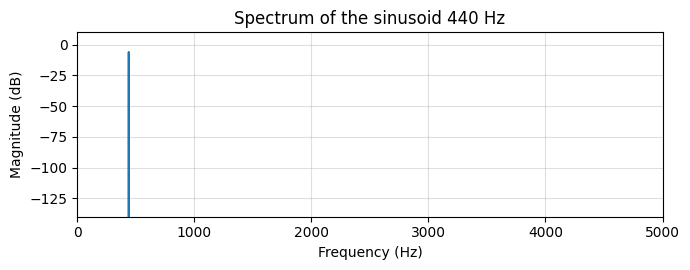

✅ Spectrum plot saved to: output/plots/step2_sine_spectrum.png


In [3]:
# --- Bloc code #3 – FFT computation + frequency plot ---

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import FS
from src.signal_generators import sine_wave

# Create output folder
Path("output/plots").mkdir(parents=True, exist_ok=True)

# ----- FFT (one-sided) -----
N = len(x)
X = np.fft.rfft(x) / N
f = np.fft.rfftfreq(N, d=1/FS)

# Magnitude in dB with flooring to avoid -inf
mag = np.abs(X)
mag_db = 20 * np.log10(np.maximum(mag, 1e-12))

# ----- Plot spectrum -----
plt.figure(figsize=(7, 2.8))
plt.plot(f, mag_db)
plt.xlim(0, 5000)  # focus on low-to-mid band; adjust as needed
plt.ylim(-140, 10)
title_freq = f"{freq:.0f} Hz" if freq is not None else ""
plt.title(f"Spectrum of the sinusoid {title_freq}".strip())
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True, which='both', alpha=0.4)
plt.tight_layout()

# Save plot
plot_path = "output/plots/step2_sine_spectrum.png"
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"✅ Spectrum plot saved to: {plot_path}")


## 2.4 Other waveform types

*(lecture 2 – Linear systems and harmonic content; hands-on “Fourier analysis”)*  

To create richer timbres, synthesizers use other **periodic waveforms**:

* **Square wave:** contains only odd harmonics → “hollow” tone
* **Triangle wave:** odd harmonics with amplitude decreasing as (1/n^2) → “soft” tone
* **Sawtooth wave:** all harmonics → “bright” or “buzzy” tone



👉 **Bloc code #4 – generation of square, triangle, and sawtooth signals**

By plotting their spectra, we can clearly see the harmonic patterns predicted by Fourier series theory.
These shapes determine the **timbre** and perceptual brightness of the sound.



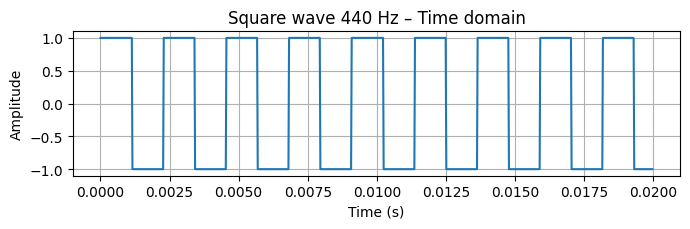

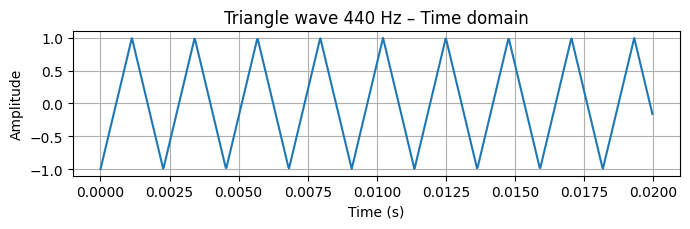

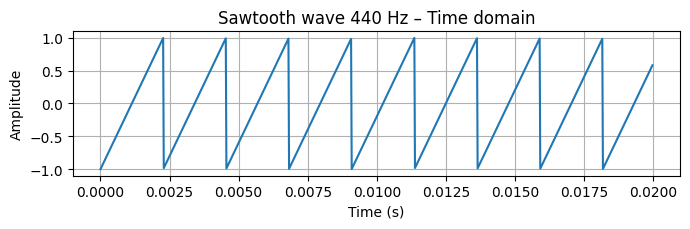

✅ Waveforms generated and saved:
   • Audio: output/sounds/step2_square.wav, step2_triangle.wav, step2_sawtooth.wav
   • Plots:
     - output/plots/step2_square_time.png
     - output/plots/step2_triangle_time.png
     - output/plots/step2_saw_time.png


In [4]:
# --- Bloc code #4 – Generation of square, triangle, and sawtooth signals (final version) ---

from src.signal_generators import square_wave, triangle_wave, sawtooth_wave
from src.visualization import plot_and_save_time
from src.utils import FS, normalize_audio, save_wav
from pathlib import Path

# Parameters
freq = 440.0     # Hz
duration = 1.0   # seconds
amp = 1.0
view_ms = 0.02   # 20 ms for visualization

# Create output folders
Path("output/sounds").mkdir(parents=True, exist_ok=True)

# Generate waveforms
x_square   = square_wave(freq, duration=duration, amp=amp, fs=FS)
x_triangle = triangle_wave(freq, duration=duration, amp=amp, fs=FS)
x_saw      = sawtooth_wave(freq, duration=duration, amp=amp, fs=FS)

# Plot and save time-domain figures
plot_square   = plot_and_save_time(x_square,   FS, view_ms, "Square wave 440 Hz – Time domain",   "step2_square_time.png")
plot_triangle = plot_and_save_time(x_triangle, FS, view_ms, "Triangle wave 440 Hz – Time domain", "step2_triangle_time.png")
plot_saw      = plot_and_save_time(x_saw,      FS, view_ms, "Sawtooth wave 440 Hz – Time domain", "step2_saw_time.png")

# Save normalized audio
save_wav("output/sounds/step2_square.wav",   normalize_audio(x_square),  FS)
save_wav("output/sounds/step2_triangle.wav", normalize_audio(x_triangle),FS)
save_wav("output/sounds/step2_sawtooth.wav", normalize_audio(x_saw),     FS)

# Final summary
print("✅ Waveforms generated and saved:")
print("   • Audio: output/sounds/step2_square.wav, step2_triangle.wav, step2_sawtooth.wav")
print("   • Plots:")
print(f"     - {plot_square}")
print(f"     - {plot_triangle}")
print(f"     - {plot_saw}")


👉 **Bloc code #5 – FFT + comparative spectrum plots**

---



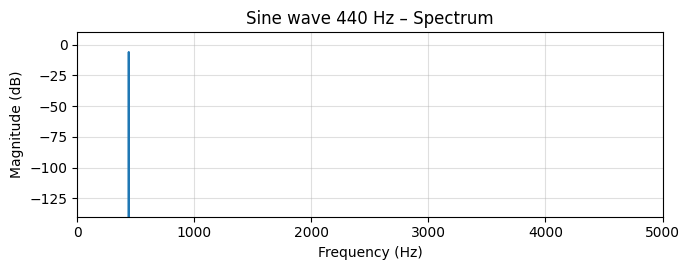

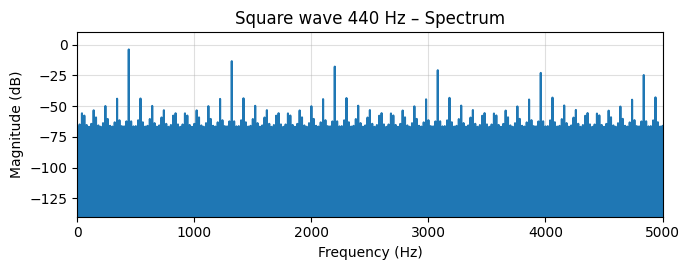

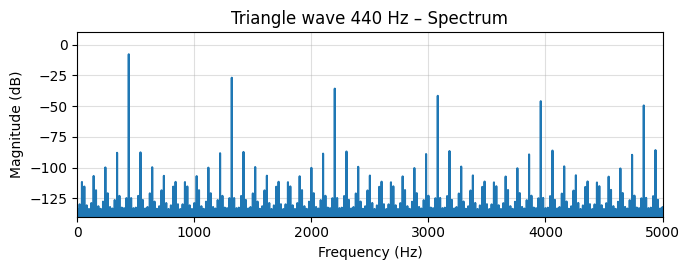

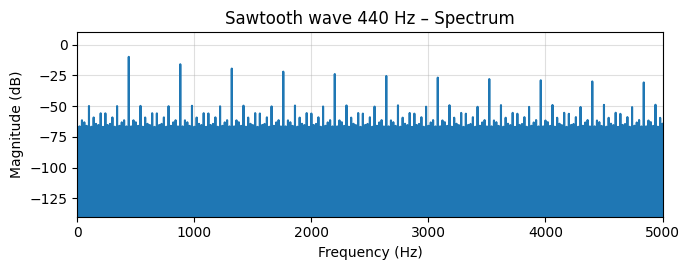

✅ Spectrum plots generated and saved:
   • Plots:
     - output/plots/step2_sine_spectrum.png
     - output/plots/step2_square_spectrum.png
     - output/plots/step2_triangle_spectrum.png
     - output/plots/step2_saw_spectrum.png


In [5]:
# --- Bloc code #5 – FFT + Comparative spectrum plots ---

from src.visualization import plot_and_save_spectrum
from src.signal_generators import square_wave, triangle_wave, sawtooth_wave, sine_wave
from src.utils import FS

freq = 440.0
duration = 1.0
amp = 1.0

# Generate the 4 main waveforms
x_sine     = sine_wave(freq, duration=duration, amp=amp, fs=FS)
x_square   = square_wave(freq, duration=duration, amp=amp, fs=FS)
x_triangle = triangle_wave(freq, duration=duration, amp=amp, fs=FS)
x_saw      = sawtooth_wave(freq, duration=duration, amp=amp, fs=FS)

# Plot and save their spectra
plot_sine     = plot_and_save_spectrum(x_sine,     FS, "Sine wave 440 Hz – Spectrum",     "step2_sine_spectrum.png")
plot_square   = plot_and_save_spectrum(x_square,   FS, "Square wave 440 Hz – Spectrum",   "step2_square_spectrum.png")
plot_triangle = plot_and_save_spectrum(x_triangle, FS, "Triangle wave 440 Hz – Spectrum", "step2_triangle_spectrum.png")
plot_saw      = plot_and_save_spectrum(x_saw,      FS, "Sawtooth wave 440 Hz – Spectrum", "step2_saw_spectrum.png")

# Final summary
print("✅ Spectrum plots generated and saved:")
print("   • Plots:")
print(f"     - {plot_sine}")
print(f"     - {plot_square}")
print(f"     - {plot_triangle}")
print(f"     - {plot_saw}")


## 2.5 Observations

* The **oscillator** is the first and most essential component of a synthesizer.
* Its role is to define the **frequency content** (and thus the tonal color) of the signal.
* The waveform type determines the **harmonic richness** and perceived character.
* In the next section, we will **shape** these raw waveforms over time using an **ADSR envelope**, directly linked to amplitude modulation concepts *(lecture 2 – LTI scaling and modulation)*. 


# 3. ADSR Envelope Generator

After generating steady periodic signals, we now need to **shape their amplitude over time** to make them sound more natural or expressive.
This is achieved using an **ADSR envelope**, a simple model of how sound evolves from the moment it starts until it fades out.

---

## 3.1 Theoretical background

*(lecture 2 – Linear systems and time-domain operations; hands-on “Amplitude modulation and windowing”)*  

In musical acoustics, every note follows a specific temporal pattern of loudness, typically divided into four stages:

1. **Attack (A):** time it takes to reach maximum amplitude after the note starts.
2. **Decay (D):** short period after the attack during which amplitude decreases to the sustain level.
3. **Sustain (S):** steady level maintained while the note is held.
4. **Release (R):** time for amplitude to fall back to zero once the note stops.

The ADSR envelope can be represented as a piecewise function (e[n]) that multiplies the generated waveform (x[n]):

[
y[n] = x[n] \cdot e[n]
]

This is a form of **amplitude modulation**, i.e. applying a slowly varying gain function to a faster oscillating signal.
It is conceptually identical to **multiplying by a window** in signal processing *(hands-on “Amplitude modulation and windowing”)*. 

The envelope can have **linear** or **exponential** segments: exponential shapes often sound more natural to the ear.

---

## 3.2 Implementation of the ADSR function

*(hands-on “Windowing and modulation”)* 

We implement a function that builds a normalized envelope according to the given durations (A, D, S, R), sustain level, total duration, and sampling frequency.



👉 **Bloc code #6 – function definition**
*(function `generate_adsr(A, D, S, R, sustain_level, fs, total_time)` that returns `env[n]`)*

Each section is constructed as a linear ramp (or exponential if specified), concatenated into a single envelope vector of length `fs × total_time`.

---



In [6]:
# --- Bloc code #6 – ADSR function (definition via alias + sanity check) ---

from src.envelope_adsr import adsr_envelope as generate_adsr
from src.utils import FS

# Example parameters
A = 0.10     # attack (s)
D = 0.20     # decay (s)
S = 0.60     # sustain level (0–1)
S_time = 0.80  # sustain time (s)
R = 0.30     # release (s)

# Generate the envelope (env) and corresponding time vector (t_env)
env, t_env = generate_adsr(
    attack=A,
    decay=D,
    sustain_level=S,
    sustain_time=S_time,
    release=R,
    fs=FS
)

# Sanity check / summary
dur_total = len(env) / FS
print("✅ ADSR envelope generated")
print(f"   • Durations (s): A={A}, D={D}, S_time={S_time}, R={R}")
print(f"   • Sustain level: {S:.2f}")
print(f"   • Sampling rate: {FS} Hz")
print(f"   • Total length : {len(env)} samples ({dur_total:.3f} s)")



✅ ADSR envelope generated
   • Durations (s): A=0.1, D=0.2, S_time=0.8, R=0.3
   • Sustain level: 0.60
   • Sampling rate: 44100 Hz
   • Total length : 61740 samples (1.400 s)


## 3.3 Applying the envelope to a waveform

Once the ADSR envelope is generated, we apply it to a previously created signal by **element-wise multiplication**:

[
y[n] = x[n] \times e[n]
]



👉 **Bloc code #7 – apply ADSR envelope to a sine wave**

This operation scales the amplitude of the waveform according to the envelope.
The resulting sound now has a defined temporal structure — a “note” rather than a continuous tone.

---



In [7]:
# --- Bloc code #7 – Apply ADSR envelope to a sine wave ---

from src.signal_generators import sine_wave
from src.envelope_adsr import apply_envelope
from src.utils import FS, normalize_audio, save_wav
from pathlib import Path

# Create a sine wave matching the envelope duration
signal_duration = len(env) / FS
freq = 440.0  # A4 tone in Hz
x = sine_wave(freq, duration=signal_duration, fs=FS)

# Apply the ADSR envelope to the sine wave
x_env = apply_envelope(x, env)

# Ensure the output folder exists
Path("output/sounds").mkdir(parents=True, exist_ok=True)

# Save both versions (normalized)
save_wav("output/sounds/step3_sine_original.wav", normalize_audio(x), FS)
save_wav("output/sounds/step3_sine_adsr.wav", normalize_audio(x_env), FS)

print("✅ Sine wave and ADSR-shaped version generated and saved:")
print("   • output/sounds/step3_sine_original.wav")
print("   • output/sounds/step3_sine_adsr.wav")


✅ Sine wave and ADSR-shaped version generated and saved:
   • output/sounds/step3_sine_original.wav
   • output/sounds/step3_sine_adsr.wav


## 3.4 Visualization

Two complementary plots help to understand the effect:

* **Envelope shape:** show `e[n]` over time to verify the A/D/S/R segments.
* **Waveform before and after ADSR:** compare the raw sinusoid and the shaped output.



👉 **Bloc code #8 – plots of envelope and modulated signal**

This visual inspection confirms that the envelope acts as a multiplicative modulation, consistent with the **LTI system** theory where output amplitude scales linearly with input *(lecture 2 – Linearity and scaling properties)*. 

---



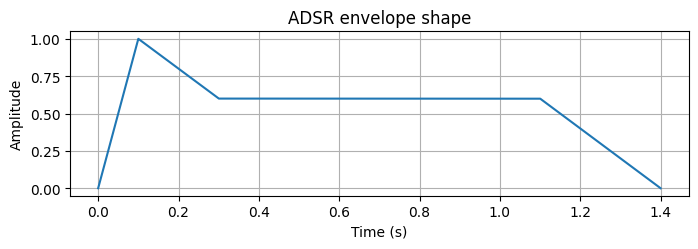

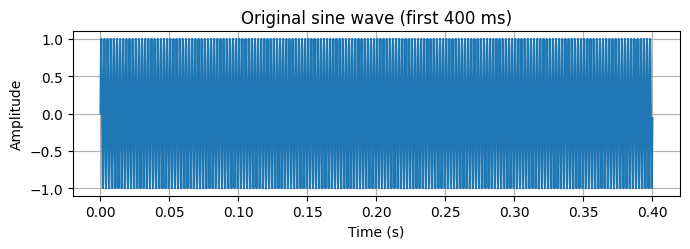

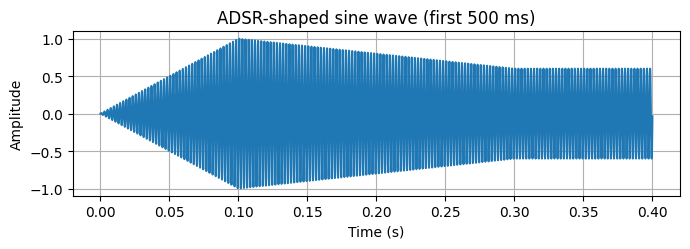

✅ Plots generated and saved:
   • Plots:
     - output/plots/step3_adsr_envelope.png
     - output/plots/step3_sine_original_time.png
     - output/plots/step3_sine_adsr_time.png


In [8]:
# --- Bloc code #8 – Plots of envelope and modulated signal (separate figures) ---

import matplotlib.pyplot as plt
from pathlib import Path
from src.utils import FS
from src.envelope_adsr import adsr_envelope as generate_adsr, apply_envelope
from src.signal_generators import sine_wave

# Ensure output folder exists
Path("output/plots").mkdir(parents=True, exist_ok=True)

# ---- Plot 1: ADSR envelope shape (full duration) ----
plt.figure(figsize=(7, 2.6))
plt.plot(t_env, env)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ADSR envelope shape")
plt.grid(True)
plt.tight_layout()
plot_env_path = "output/plots/step3_adsr_envelope.png"
plt.savefig(plot_env_path, dpi=300)
plt.show()

# ---- Plot 2: Original sine wave (first 400 ms) ----
view_seconds = 0.40
N = int(view_seconds * FS)
t_view = np.arange(N) / FS

plt.figure(figsize=(7, 2.6))
plt.plot(t_view, x[:N])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original sine wave (first 400 ms)")
plt.grid(True)
plt.tight_layout()
plot_orig_path = "output/plots/step3_sine_original_time.png"
plt.savefig(plot_orig_path, dpi=300)
plt.show()

# ---- Plot 3: ADSR-shaped sine wave (first 500 ms) ----
plt.figure(figsize=(7, 2.6))
plt.plot(t_view, x_env[:N])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ADSR-shaped sine wave (first 500 ms)")
plt.grid(True)
plt.tight_layout()
plot_envsig_path = "output/plots/step3_sine_adsr_time.png"
plt.savefig(plot_envsig_path, dpi=300)
plt.show()

# Summary
print("✅ Plots generated and saved:")
print("   • Plots:")
print(f"     - {plot_env_path}")
print(f"     - {plot_orig_path}")
print(f"     - {plot_envsig_path}")


## 3.5 Observations

* The ADSR envelope defines the **temporal dynamics** of the sound, controlling its perceived articulation.
* Different parameter choices change the perceived texture:

  * Short attack → “percussive” sound.
  * Long release → “smooth fade-out”.
* This operation corresponds to a **time-varying linear system**, where the envelope acts as a slowly changing gain.
* In the next section, we will introduce **filters**, which instead shape the **spectral content** of the sound, following the concepts of impulse response and convolution *(lecture 3 – Convolution and filter design; hands-on “Filtering and linear systems”)*.  




# 4. Filtering

After generating and shaping signals with an ADSR envelope, we can further modify their **spectral content** using filters.
Filters are linear systems that selectively amplify or attenuate certain frequency components of a signal.
They are fundamental tools in Digital Signal Processing (DSP) and essential in sound synthesis.

---

## 4.1 Theoretical background

*(lecture 3 – Convolution and Linear Time-Invariant (LTI) Systems; hands-on “Convolution, filtering and simple linear systems”)*  

An **LTI system** can be completely described by its **impulse response** (h[n]).
The output of such a system is the **convolution** of the input (x[n]) with (h[n]):

[
y[n] = (x * h)[n] = \sum_k x[k] , h[n-k]
]

In the **frequency domain**, convolution corresponds to multiplication:

[
Y(e^{j\omega}) = X(e^{j\omega}) \cdot H(e^{j\omega})
]

This means that the **magnitude** of (H(e^{j\omega})) determines which frequencies are passed or attenuated, and its **phase** defines the timing or coloration effects of the output.

Typical filter types used in synthesizers:

* **Low-pass (LPF):** passes low frequencies, removes high ones.
* **High-pass (HPF):** passes high frequencies, removes low ones.
* **Band-pass (BPF):** passes a specific frequency band.
* **Band-stop (BSF):** removes a narrow frequency band.
* **All-pass (APF):** keeps all magnitudes equal but changes the phase (used to create phase-based effects).

*(lecture 3 – Frequency response and filter examples)* 

---

## 4.2 Implementation of basic filters

*(hands-on “Filtering and simple linear systems”)* 

We will implement a generic function that applies one of the standard filter types (LPF, HPF, BPF, BSF) to a given signal.
You may use simple FIR designs, or IIR designs such as Butterworth or Chebyshev depending on your preference and the library.



👉 **Bloc code #9 – function definition**
*(function `apply_filter(signal, filter_type, cutoff, fs, order)` that returns the filtered signal)*



In [9]:
# --- Bloc code #9 – Filter function definition and quick test ---

from src.filters import design_filter, apply_filter
from src.signal_generators import sawtooth_wave
from src.utils import FS, normalize_audio, save_wav
from pathlib import Path

# Sampling rate and parameters
fs = FS
order = 4
duration = 1.0
freq = 440.0  # A4 tone

# Generate a rich harmonic signal (sawtooth wave)
x = sawtooth_wave(freq, duration=duration, fs=fs)

# Design filters
b_lp, a_lp = design_filter("lowpass", cutoff=1000, fs=fs, order=order)
b_hp, a_hp = design_filter("highpass", cutoff=1000, fs=fs, order=order)
b_bp, a_bp = design_filter("bandpass", band=(800, 2000), fs=fs, order=order)
b_ap, a_ap = design_filter("allpass", cutoff=1200, fs=fs, order=1)

# Apply filters
x_lp = apply_filter(x, b_lp, a_lp)
x_hp = apply_filter(x, b_hp, a_hp)
x_bp = apply_filter(x, b_bp, a_bp)
x_ap = apply_filter(x, b_ap, a_ap)

# Save output sounds
Path("output/sounds").mkdir(parents=True, exist_ok=True)
save_wav("output/sounds/step4_saw_original.wav", normalize_audio(x), fs)
save_wav("output/sounds/step4_saw_lp.wav", normalize_audio(x_lp), fs)
save_wav("output/sounds/step4_saw_hp.wav", normalize_audio(x_hp), fs)
save_wav("output/sounds/step4_saw_bp.wav", normalize_audio(x_bp), fs)
save_wav("output/sounds/step4_saw_ap.wav", normalize_audio(x_ap), fs)

# Summary
print("✅ Filtered signals generated and saved:")
print("   • Audio files:")
print("     - output/sounds/step4_saw_original.wav")
print("     - output/sounds/step4_saw_lp.wav")
print("     - output/sounds/step4_saw_hp.wav")
print("     - output/sounds/step4_saw_bp.wav")
print("     - output/sounds/step4_saw_ap.wav")


✅ Filtered signals generated and saved:
   • Audio files:
     - output/sounds/step4_saw_original.wav
     - output/sounds/step4_saw_lp.wav
     - output/sounds/step4_saw_hp.wav
     - output/sounds/step4_saw_bp.wav
     - output/sounds/step4_saw_ap.wav


Key parameters:

* **filter_type:** one of `"lowpass"`, `"highpass"`, `"bandpass"`, `"bandstop"`.
* **cutoff:** cutoff or passband frequencies (in Hz).
* **fs:** sampling rate.
* **order:** filter sharpness (number of taps or filter order).

After defining the function, test it by applying each filter type to a complex waveform (e.g., a sawtooth wave).



👉 **Bloc code #10 – example application of filters**

---



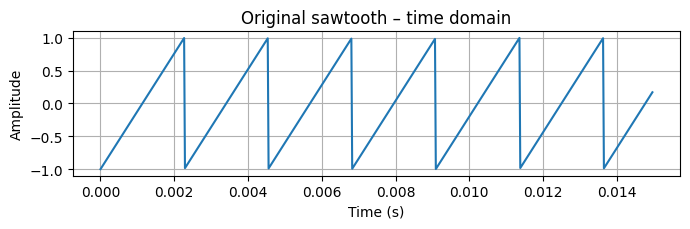

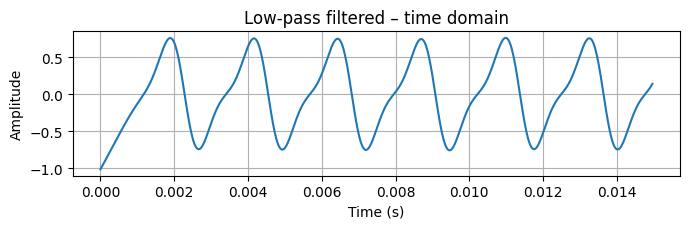

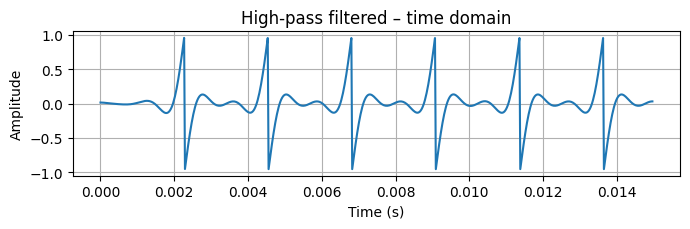

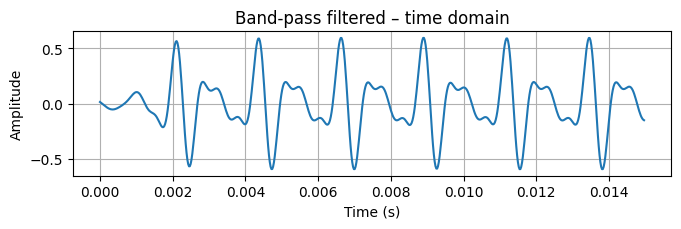

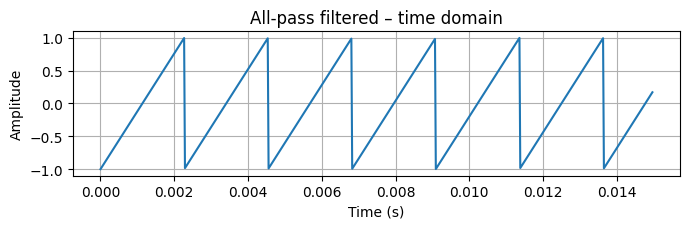

✅ Time-domain plots generated and saved:
   • Plots:
     - output/plots/step4_time_original.png
     - output/plots/step4_time_lowpass.png
     - output/plots/step4_time_highpass.png
     - output/plots/step4_time_bandpass.png
     - output/plots/step4_time_allpass.png


In [10]:
# --- Bloc code #10 – Time-domain comparisons of filtered signals (with saving) ---

from pathlib import Path
from src.visualization import plot_and_save_time
from src.filters import design_filter, apply_filter
from src.signal_generators import sawtooth_wave
from src.utils import FS

# Create output folder for plots
Path("output/plots").mkdir(parents=True, exist_ok=True)

# Plot window (seconds) – short to show a few periods clearly
view_ms = 0.015  # 15 ms

# Generate and save separate time-domain plots
p_orig = plot_and_save_time(x,    FS, view_ms, "Original sawtooth – time domain", "step4_time_original.png")
p_lp   = plot_and_save_time(x_lp, FS, view_ms, "Low-pass filtered – time domain", "step4_time_lowpass.png")
p_hp   = plot_and_save_time(x_hp, FS, view_ms, "High-pass filtered – time domain", "step4_time_highpass.png")
p_bp   = plot_and_save_time(x_bp, FS, view_ms, "Band-pass filtered – time domain", "step4_time_bandpass.png")
p_ap   = plot_and_save_time(x_ap, FS, view_ms, "All-pass filtered – time domain", "step4_time_allpass.png")

# Summary (preferred format)
print("✅ Time-domain plots generated and saved:")
print("   • Plots:")
print(f"     - {p_orig}")
print(f"     - {p_lp}")
print(f"     - {p_hp}")
print(f"     - {p_bp}")
print(f"     - {p_ap}")


## 4.3 Visualizing filter behavior

*(hands-on “Fourier analysis of digital signals”)* 

To better understand the effect of the filter:

* **Impulse response plot:** shows how the filter reacts in the time domain.
* **Magnitude response plot:** illustrates which frequencies are passed or attenuated.
* **Comparison:** overlay the spectrum of the input and output signals.



👉 **Bloc code #11 – plot impulse response and magnitude/frequency responses**

The low-pass filter should attenuate high-frequency harmonics, while the high-pass removes the fundamental and keeps upper partials.
This behavior directly reflects the convolution theory introduced in *lecture 3*. 

---



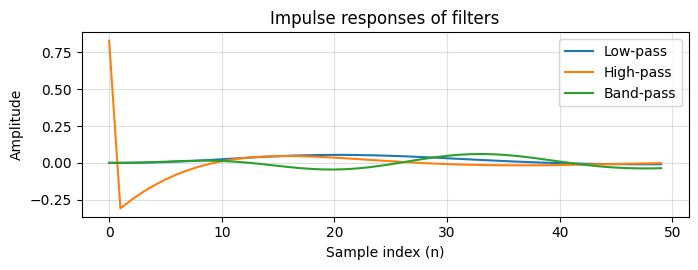

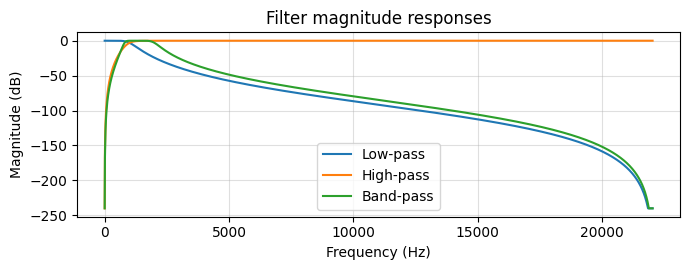

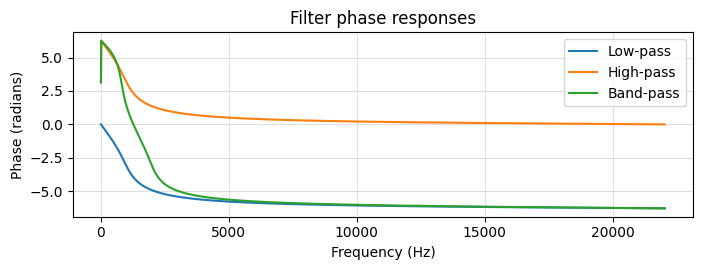

✅ Filter analysis plots generated and saved:
   • Plots:
     - output/plots/step4_filter_impulse_responses.png
     - output/plots/step4_filter_magnitude_responses.png
     - output/plots/step4_filter_phase_responses.png


In [11]:
# --- Bloc code #11 – Plot impulse response and magnitude/phase responses ---

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.filters import design_filter, freq_response
from src.utils import FS

# Ensure output directory exists
Path("output/plots").mkdir(parents=True, exist_ok=True)

# Sampling rate and filter parameters
fs = FS
order = 4

# Define filter designs
filters = {
    "Low-pass":  design_filter("lowpass", cutoff=1000, fs=fs, order=order),
    "High-pass": design_filter("highpass", cutoff=1000, fs=fs, order=order),
    "Band-pass": design_filter("bandpass", band=(800, 2000), fs=fs, order=order),
}

# ---- Plot 1: Impulse responses ----
plt.figure(figsize=(7, 2.8))
impulse = np.zeros(50)
impulse[0] = 1.0  # unit impulse
for name, (b, a) in filters.items():
    h = np.zeros_like(impulse)
    # Compute impulse response using lfilter
    from scipy.signal import lfilter
    h = lfilter(b, a, impulse)
    plt.plot(h, label=name)

plt.xlabel("Sample index (n)")
plt.ylabel("Amplitude")
plt.title("Impulse responses of filters")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
path_impulse = "output/plots/step4_filter_impulse_responses.png"
plt.savefig(path_impulse, dpi=300)
plt.show()

# ---- Plot 2: Magnitude responses ----
plt.figure(figsize=(7, 2.8))
for name, (b, a) in filters.items():
    w, mag, phase = freq_response(b, a, fs)
    plt.plot(w, mag, label=name)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Filter magnitude responses")
plt.grid(True, which="both", alpha=0.4)
plt.legend()
plt.tight_layout()
path_mag = "output/plots/step4_filter_magnitude_responses.png"
plt.savefig(path_mag, dpi=300)
plt.show()

# ---- Plot 3: Phase responses ----
plt.figure(figsize=(7, 2.8))
for name, (b, a) in filters.items():
    w, mag, phase = freq_response(b, a, fs)
    plt.plot(w, phase, label=name)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.title("Filter phase responses")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
path_phase = "output/plots/step4_filter_phase_responses.png"
plt.savefig(path_phase, dpi=300)
plt.show()

# Summary
print("✅ Filter analysis plots generated and saved:")
print("   • Plots:")
print(f"     - {path_impulse}")
print(f"     - {path_mag}")
print(f"     - {path_phase}")


## 4.4 All-pass filters and cascades

*(lecture 3 – Phase response; hands-on “Filtering and system analysis”)*  

An **all-pass filter (APF)** keeps the amplitude spectrum flat but changes the **phase** of the signal.
Although the energy remains the same, the altered phase relationship can create a **“rough” or “spatial”** effect in sound synthesis.
Cascading multiple APFs increases this effect, producing a sense of diffusion or resonance.



👉 **Bloc code #12 – design and application of an all-pass filter (single and cascaded versions)**

Visualize both the **phase response** and the resulting waveform distortion, confirming that amplitude remains unchanged while the phase is shifted.

---



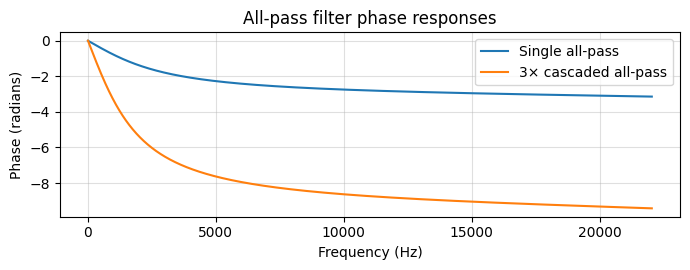

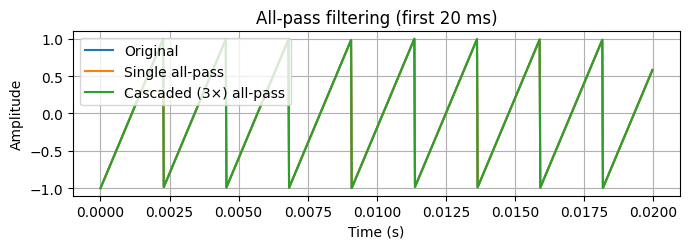

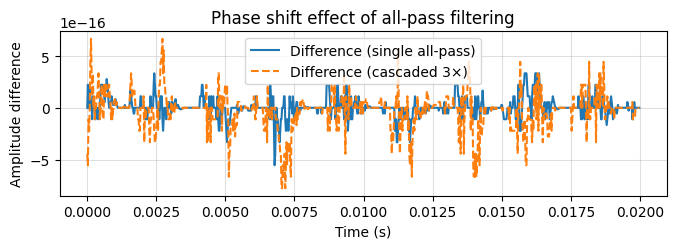

✅ All-pass filter analysis completed:
   • Audio:
     - output/sounds/step4_allpass_single.wav
     - output/sounds/step4_allpass_cascade.wav
   • Plots:
     - output/plots/step4_allpass_phase_responses.png
     - output/plots/step4_allpass_time_comparison.png
     - output/plots/step4_allpass_phase_difference.png


In [12]:
# --- Bloc code #12 – All-pass filter: single, cascaded, and phase difference visualization ---

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.filters import design_filter, apply_filter, freq_response
from src.signal_generators import sawtooth_wave
from src.utils import FS, normalize_audio, save_wav

# Ensure output folders exist
Path("output/sounds").mkdir(parents=True, exist_ok=True)
Path("output/plots").mkdir(parents=True, exist_ok=True)

# Sampling parameters
fs = FS
duration = 1.0
freq = 440.0

# Generate a bright harmonic-rich signal (sawtooth)
x = sawtooth_wave(freq, duration=duration, fs=fs)

# --- Single all-pass filter ---
b_ap1, a_ap1 = design_filter("allpass", cutoff=1200, fs=fs, order=1)
y_ap1 = apply_filter(x, b_ap1, a_ap1)

# --- Cascaded all-pass filter (3 stages) ---
y_ap_cascade = x.copy()
for _ in range(3):
    b_ap, a_ap = design_filter("allpass", cutoff=800, fs=fs, order=1)
    y_ap_cascade = apply_filter(y_ap_cascade, b_ap, a_ap)

# Save output sounds
save_wav("output/sounds/step4_allpass_single.wav", normalize_audio(y_ap1), fs)
save_wav("output/sounds/step4_allpass_cascade.wav", normalize_audio(y_ap_cascade), fs)

# --- Plot 1: Phase responses ---
plt.figure(figsize=(7, 2.8))
w1, _, phase1 = freq_response(b_ap1, a_ap1, fs)
plt.plot(w1, phase1, label="Single all-pass")

# Approximate phase response for the cascaded filter
b_ap, a_ap = design_filter("allpass", cutoff=800, fs=fs, order=1)
w3, _, phase3 = freq_response(b_ap, a_ap, fs)
plt.plot(w3, 3 * phase3, label="3× cascaded all-pass")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.title("All-pass filter phase responses")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plot_phase = "output/plots/step4_allpass_phase_responses.png"
plt.savefig(plot_phase, dpi=300)
plt.show()

# --- Plot 2: Time-domain waveforms (first 20 ms) ---
view_time = 0.02
N = int(view_time * fs)
t = np.arange(N) / fs

plt.figure(figsize=(7, 2.6))
plt.plot(t, x[:N], label="Original")
plt.plot(t, y_ap1[:N], label="Single all-pass")
plt.plot(t, y_ap_cascade[:N], label="Cascaded (3×) all-pass")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("All-pass filtering (first 20 ms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plot_time = "output/plots/step4_allpass_time_comparison.png"
plt.savefig(plot_time, dpi=300)
plt.show()

# --- Plot 3: Difference signal (emphasizes phase shift) ---
diff_single = x[:N] - y_ap1[:N]
diff_cascade = x[:N] - y_ap_cascade[:N]

plt.figure(figsize=(7, 2.6))
plt.plot(t, diff_single, label="Difference (single all-pass)")
plt.plot(t, diff_cascade, label="Difference (cascaded 3×)", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude difference")
plt.title("Phase shift effect of all-pass filtering")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plot_diff = "output/plots/step4_allpass_phase_difference.png"
plt.savefig(plot_diff, dpi=300)
plt.show()

# Summary
print("✅ All-pass filter analysis completed:")
print("   • Audio:")
print("     - output/sounds/step4_allpass_single.wav")
print("     - output/sounds/step4_allpass_cascade.wav")
print("   • Plots:")
print(f"     - {plot_phase}")
print(f"     - {plot_time}")
print(f"     - {plot_diff}")


## 4.5 Observations

* Filters shape the **spectral envelope** of the sound — they determine which harmonics are emphasized or suppressed.
* They are the **spectral counterpart** of the ADSR envelope (which acts in time).
* All-pass filters are useful for creating **phase-based effects** such as phasers or artificial reverberation.
* The link to the theoretical content is direct: the filter operation corresponds to **convolution in the time domain** and **multiplication in the frequency domain** *(lecture 3 – LTI system theory)*. 
* In the next section, we will **combine** oscillators, envelopes, and filters to synthesize complete sounds *(hands-on “System combinations and modulation experiments”)*. 


# 5. Sound Synthesis

Now that all the basic components — oscillators, envelopes, and filters — are implemented, we can combine them to create a **complete digital sound synthesis**.
In this section, we design and build a short **techno-inspired sequence (≈ 30 seconds)** that illustrates both *creative sound design* and *digital signal processing principles*.

---

## 5.1 Design goal: a techno-inspired soundscape

*(lecture 4 – System combinations and modulation; hands-on “Combining signals and systems”)*

The goal is to build a **short rhythmic techno sequence**, combining several synthesized sound elements:

* 🎛 **Kick drum** → low-frequency sine with fast attack & decay (ADSR)
* 🌀 **Hi-hat** → filtered white noise with short bursts
* 🔊 **Bassline** → sawtooth wave modulated by a slow ADSR + low-pass filter
* ✨ **Pad / drone** → sustained sound with all-pass filtering for spatial diffusion

Each sound will be generated using the modules from previous sections and combined into a simple rhythmic loop.
This type of sound design highlights how *signal addition, multiplication, modulation, and filtering* can be orchestrated to produce a coherent musical output.

---

## 5.2 Building the sound components

We will design four sound modules, each reusing the theoretical and practical material from the course:

1. **Kick** → sinusoid (~60 Hz), short attack and decay, no sustain, light distortion.
2. **Hi-hat** → white noise, band-pass filter (~8–12 kHz), short burst ADSR.
3. **Bassline** → sawtooth (~110 Hz), slow ADSR, low-pass filter (~1 kHz).
4. **Pad / drone** → square wave (~220 Hz), long ADSR, cascaded all-pass filters.

All of them will be synchronized in time and combined through addition to form the final 30 s track.



👉 **Bloc code #13 – Define and combine oscillators (kick, hi-hat, bassline, pad)**


In [13]:
# --- Block #13 – Define individual oscillators (kick, hi-hat, bassline, pad) ---

import numpy as np
from pathlib import Path
from src.signal_generators import sine_wave, sawtooth_wave, white_noise
from src.utils import FS, normalize_audio, save_wav

# Ensure output directory exists
Path("output/sounds").mkdir(parents=True, exist_ok=True)

fs = FS
dur = 2.0  # default base duration (seconds) — used for consistency

# --- KICK ---
# Deep sine wave (~90 Hz), short and clean — base of the beat
# Will later get a sharp ADSR and low-pass filtering
kick_wave   = sine_wave(80, dur, fs)

# --- HI-HAT ---
# White noise burst for percussive high frequencies
hihat_wave  = white_noise(dur, fs)

# --- BASS ---
# Sawtooth wave (~110 Hz) gives a rich harmonic bassline
bass_wave   = sawtooth_wave(110, dur, fs)

# --- PAD ---
# Smooth sine wave (~220 Hz), to be shaped with slow ADSR and filter
# remplace ta ligne pad_wave = ...
pad_wave = sine_wave(220, dur, fs)

# --- Save raw sound components (normalized for listening) ---
save_wav("output/sounds/step5_kick_raw.wav",  normalize_audio(kick_wave),  fs)
save_wav("output/sounds/step5_hihat_raw.wav", normalize_audio(hihat_wave), fs)
save_wav("output/sounds/step5_bass_raw.wav",  normalize_audio(bass_wave),  fs)
save_wav("output/sounds/step5_pad_raw.wav",   normalize_audio(pad_wave),   fs)

print("✅ Raw sound components generated and saved:")
print("   • Kick  → output/sounds/step5_kick_raw.wav")
print("   • Hi-hat → output/sounds/step5_hihat_raw.wav")
print("   • Bass  → output/sounds/step5_bass_raw.wav")
print("   • Pad   → output/sounds/step5_pad_raw.wav")


✅ Raw sound components generated and saved:
   • Kick  → output/sounds/step5_kick_raw.wav
   • Hi-hat → output/sounds/step5_hihat_raw.wav
   • Bass  → output/sounds/step5_bass_raw.wav
   • Pad   → output/sounds/step5_pad_raw.wav


👉 **Bloc code #14 – Apply ADSR envelopes to each component**


In [14]:
# --- Block #14 – Apply ADSR envelopes to each component (using your exact params) ---

import numpy as np
from pathlib import Path

from src.envelope_adsr import adsr_envelope as generate_adsr, apply_envelope
from src.signal_generators import sine_wave, sawtooth_wave, white_noise
from src.utils import FS, normalize_audio, save_wav

# Ensure output directory exists
Path("output/sounds").mkdir(parents=True, exist_ok=True)

fs = FS

# Helper to compute sustain_time so that A + D + sustain_time + R ~= signal duration
def sustain_time_for(signal_len, fs, A, D, R):
    total = signal_len / fs
    return max(0.0, total - (A + D + R))

# ---------------------------------------------------------------
# ADSR parameter sets
# ---------------------------------------------------------------
kick_adsr_cfg = dict(attack=0.002, decay=0.12, sustain_level=0.0, release=0.05)
hihat_adsr_cfg = dict(attack=0.003, decay=0.08, sustain_level=0.0, release=0.03)
bass_adsr_cfg  = dict(attack=0.02,  decay=0.30, sustain_level=0.7, release=0.20)
pad_adsr_cfg = dict(attack=1.5, decay=1.2, sustain_level=0.85, release=2.5)


# Compute sustain_time per signal (so envelope fits the waveform length)
kick_st  = sustain_time_for(len(kick_wave),  fs, kick_adsr_cfg["attack"],  kick_adsr_cfg["decay"],  kick_adsr_cfg["release"])
hat_st   = sustain_time_for(len(hihat_wave), fs, hihat_adsr_cfg["attack"], hihat_adsr_cfg["decay"], hihat_adsr_cfg["release"])
bass_st  = sustain_time_for(len(bass_wave),  fs, bass_adsr_cfg["attack"],  bass_adsr_cfg["decay"],  bass_adsr_cfg["release"])
pad_st   = sustain_time_for(len(pad_wave),   fs, pad_adsr_cfg["attack"],   pad_adsr_cfg["decay"],   pad_adsr_cfg["release"])

# Generate envelopes
env_kick, _  = generate_adsr(fs=fs, sustain_time=kick_st,  **kick_adsr_cfg)
env_hat,  _  = generate_adsr(fs=fs, sustain_time=hat_st,   **hihat_adsr_cfg)
env_bass, _  = generate_adsr(fs=fs, sustain_time=bass_st,  **bass_adsr_cfg)
env_pad,  _  = generate_adsr(fs=fs, sustain_time=pad_st,   **pad_adsr_cfg)

# Apply envelopes (apply_envelope trims to min length)
kick_adsr  = apply_envelope(kick_wave,  env_kick)
hihat_adsr = apply_envelope(hihat_wave, env_hat)
bass_adsr  = apply_envelope(bass_wave,  env_bass)
pad_adsr   = apply_envelope(pad_wave,   env_pad)

# Save processed components
save_wav("output/sounds/step5_kick_adsr.wav",   normalize_audio(kick_adsr),  fs)
save_wav("output/sounds/step5_hihat_adsr.wav",  normalize_audio(hihat_adsr), fs)
save_wav("output/sounds/step5_bass_adsr.wav",   normalize_audio(bass_adsr),  fs)
save_wav("output/sounds/step5_pad_adsr.wav",    normalize_audio(pad_adsr),   fs)

# Summary
print("✅ ADSR applied (using your exact parameters) and saved:")
print("   • output/sounds/step5_kick_adsr.wav")
print("   • output/sounds/step5_hihat_adsr.wav")
print("   • output/sounds/step5_bass_adsr.wav")
print("   • output/sounds/step5_pad_adsr.wav")


✅ ADSR applied (using your exact parameters) and saved:
   • output/sounds/step5_kick_adsr.wav
   • output/sounds/step5_hihat_adsr.wav
   • output/sounds/step5_bass_adsr.wav
   • output/sounds/step5_pad_adsr.wav


👉 **Bloc code #15 – Apply appropriate filters and mix signals**

Each step includes short comments, plots, and justifications based on sound perception (e.g., “low-pass makes the bass rounder,” “high-pass brightens the hi-hat”).

---



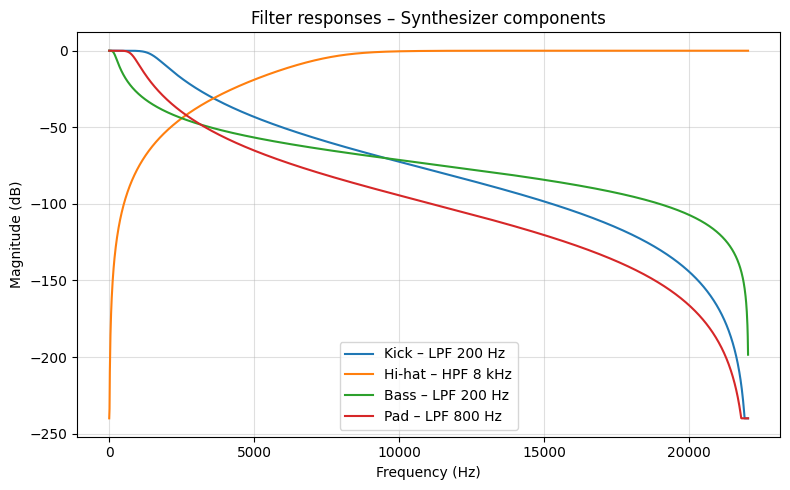

✅ Filters applied and saved (exact parameter set):
   • Kick: Low-pass 1500 Hz (order 4)
   • Hi-hat: High-pass 8 kHz (order 4)
   • Bass: Low-pass 200 Hz (order 2)
   • Pad: Low-pass 800 Hz (order 4)
   • Filter responses plot saved to: output/plots/step5_filter_responses_exact.png


In [15]:
# --- Block #15 – Apply filters to ADSR-shaped components (using your exact parameters) ---

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.filters import design_filter, apply_filter, freq_response
from src.utils import FS, normalize_audio, save_wav

# Ensure output folders exist
Path("output/sounds").mkdir(parents=True, exist_ok=True)
Path("output/plots").mkdir(parents=True, exist_ok=True)

fs = FS

# ---------------------------------------------------------------
# Filter definitions (as per your specified design)
# ---------------------------------------------------------------
kick_filter  = dict(type="lowpass", cutoff=1500, order=4)
hihat_filter = dict(type="highpass", cutoff=8000, order=4)
bass_filter  = dict(type="lowpass", cutoff=200, order=2)
pad_filter   = dict(type="lowpass", cutoff=800, order=4)

# ---------------------------------------------------------------
# Apply filters
# ---------------------------------------------------------------
b_kick, a_kick = design_filter(kick_filter["type"], cutoff=kick_filter["cutoff"], order=kick_filter["order"], fs=fs)
kick_filt = apply_filter(kick_adsr, b_kick, a_kick)

b_hat, a_hat = design_filter(hihat_filter["type"], cutoff=hihat_filter["cutoff"], order=hihat_filter["order"], fs=fs)
hihat_filt = apply_filter(hihat_adsr, b_hat, a_hat)

b_bass, a_bass = design_filter(bass_filter["type"], cutoff=bass_filter["cutoff"], order=bass_filter["order"], fs=fs)
bass_filt = apply_filter(bass_adsr, b_bass, a_bass)

b_pad, a_pad = design_filter(pad_filter["type"], cutoff=pad_filter["cutoff"], order=pad_filter["order"], fs=fs)
pad_filt = apply_filter(pad_adsr, b_pad, a_pad)

# ---------------------------------------------------------------
# Plot magnitude responses for all filters
# ---------------------------------------------------------------
plt.figure(figsize=(8, 5))
filters = {
    "Kick – LPF 200 Hz": (b_kick, a_kick),
    "Hi-hat – HPF 8 kHz": (b_hat, a_hat),
    "Bass – LPF 200 Hz": (b_bass, a_bass),
    "Pad – LPF 800 Hz": (b_pad, a_pad),
}
for label, (b, a) in filters.items():
    w, mag_db, _ = freq_response(b, a, fs)
    plt.plot(w, mag_db, label=label)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Filter responses – Synthesizer components")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plot_filters = "output/plots/step5_filter_responses_exact.png"
plt.savefig(plot_filters, dpi=300)
plt.show()

# ---------------------------------------------------------------
# Save filtered versions (normalized for preview)
# ---------------------------------------------------------------
save_wav("output/sounds/step5_kick_filtered.wav",  normalize_audio(kick_filt),  fs)
save_wav("output/sounds/step5_hihat_filtered.wav", normalize_audio(hihat_filt), fs)
save_wav("output/sounds/step5_bass_filtered.wav",  normalize_audio(bass_filt),  fs)
save_wav("output/sounds/step5_pad_filtered.wav",   normalize_audio(pad_filt),   fs)

# ---------------------------------------------------------------
# Summary
# ---------------------------------------------------------------
print("✅ Filters applied and saved (exact parameter set):")
print("   • Kick: Low-pass 1500 Hz (order 4)")
print("   • Hi-hat: High-pass 8 kHz (order 4)")
print("   • Bass: Low-pass 200 Hz (order 2)")
print("   • Pad: Low-pass 800 Hz (order 4)")
print(f"   • Filter responses plot saved to: {plot_filters}")


## 5.3 Visualization and analysis

*(hands-on “Fourier analysis of digital signals” + “System behavior exploration”)*

After synthesis, we analyze the combined output to link the perceived sound to the underlying DSP operations:

* **Time-domain waveform** → confirms rhythmic structure and envelope shaping.
* **Frequency spectrum (FFT)** → shows how different frequency bands contribute to the mix.



👉 **Bloc code #16 – Plots of time waveform, FFT spectrum**

This ensures that the final result isn’t only musical but also an analytical demonstration of **signal superposition and spectral shaping** (*lecture 4 – LTI system combinations*).

---



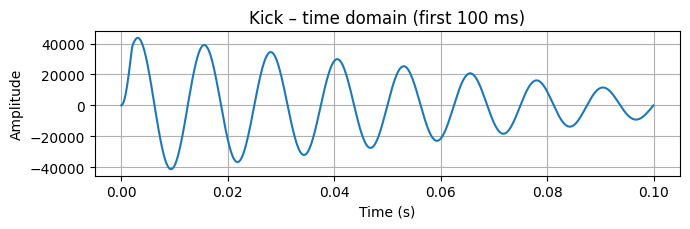

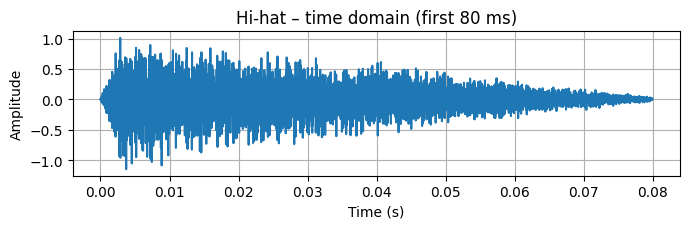

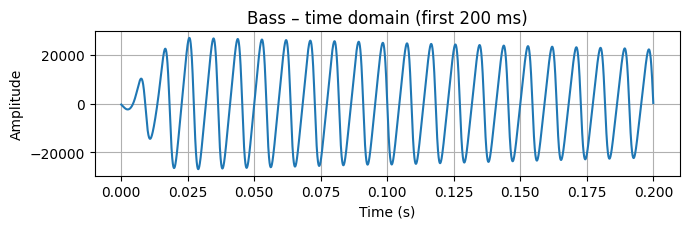

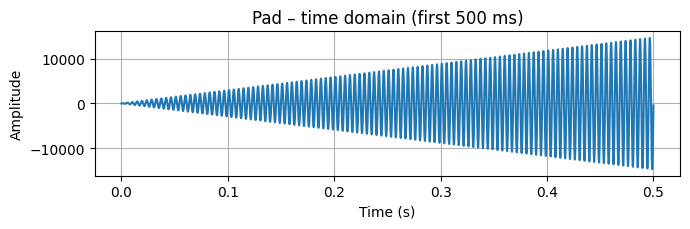

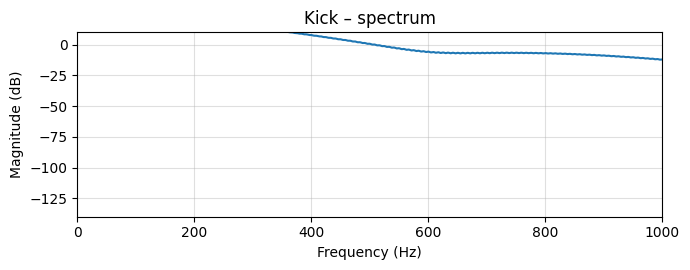

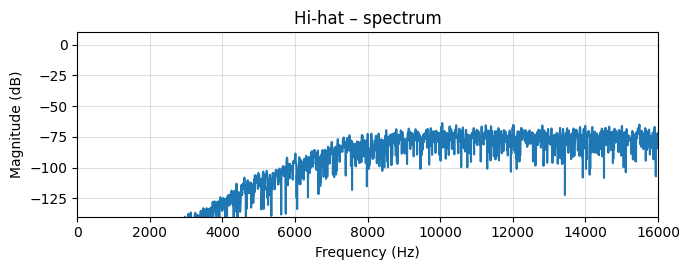

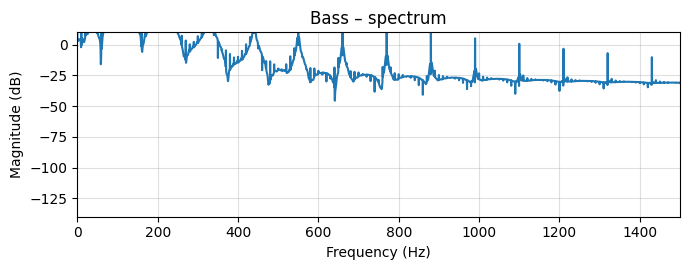

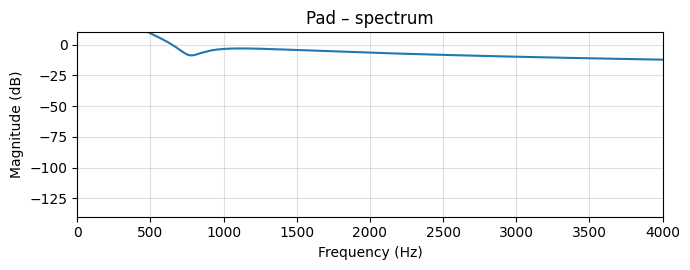

✅ Visualization generated and saved:
   • Time-domain plots:
     - output/plots/step6_kick_time.png
     - output/plots/step6_hihat_time.png
     - output/plots/step6_bass_time.png
     - output/plots/step6_pad_time.png
   • Spectrum plots:
     - output/plots/step6_kick_spectrum.png
     - output/plots/step6_hihat_spectrum.png
     - output/plots/step6_bass_spectrum.png
     - output/plots/step6_pad_spectrum.png


In [16]:
# --- Block #16 – Visualization (time, spectrum) for filtered stems ---

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import FS, normalize_audio
from src.visualization import plot_and_save_time, plot_and_save_spectrum

# Ensure output directory exists
Path("output/plots").mkdir(parents=True, exist_ok=True)

fs = FS

# ---------------------------------------------------------------------
# 1) Time-domain snapshots (separate figures, short windows)
# ---------------------------------------------------------------------
p_kick_t  = plot_and_save_time(kick_filt,  fs, tmax=0.10, title="Kick – time domain (first 100 ms)",     filename="step6_kick_time.png")
p_hat_t   = plot_and_save_time(hihat_filt, fs, tmax=0.08, title="Hi-hat – time domain (first 80 ms)",    filename="step6_hihat_time.png")
p_bass_t  = plot_and_save_time(bass_filt,  fs, tmax=0.20, title="Bass – time domain (first 200 ms)",     filename="step6_bass_time.png")
p_pad_t   = plot_and_save_time(pad_filt,   fs, tmax=0.50, title="Pad – time domain (first 500 ms)",       filename="step6_pad_time.png")

# ---------------------------------------------------------------------
# 2) Spectrum (separate figures, tailored fmax)
# ---------------------------------------------------------------------
p_kick_f  = plot_and_save_spectrum(kick_filt,  fs, title="Kick – spectrum",   filename="step6_kick_spectrum.png",  fmax=1000)
p_hat_f   = plot_and_save_spectrum(hihat_filt, fs, title="Hi-hat – spectrum", filename="step6_hihat_spectrum.png", fmax=16000)
p_bass_f  = plot_and_save_spectrum(bass_filt,  fs, title="Bass – spectrum",   filename="step6_bass_spectrum.png",  fmax=1500)
p_pad_f   = plot_and_save_spectrum(pad_filt,   fs, title="Pad – spectrum",    filename="step6_pad_spectrum.png",   fmax=4000)

# ---------------------------------------------------------------------
# 3) Mix (sum of stems) and spectrogram
# ---------------------------------------------------------------------
# Align to shortest length and sum
min_len = min(len(kick_filt), len(hihat_filt), len(bass_filt), len(pad_filt))
mix = kick_filt[:min_len] + hihat_filt[:min_len] + bass_filt[:min_len] + pad_filt[:min_len]
mix = normalize_audio(mix)

# ---------------------------------------------------------------------
# 4) Summary
# ---------------------------------------------------------------------
print("✅ Visualization generated and saved:")
print("   • Time-domain plots:")
print(f"     - {p_kick_t}")
print(f"     - {p_hat_t}")
print(f"     - {p_bass_t}")
print(f"     - {p_pad_t}")
print("   • Spectrum plots:")
print(f"     - {p_kick_f}")
print(f"     - {p_hat_f}")
print(f"     - {p_bass_f}")
print(f"     - {p_pad_f}")


## 5.4 Export and playback

*(hands-on “Data I/O: Writing audio files”)*

The 30 s sequence will be exported as a `.wav` file, normalized to prevent clipping and suitable for playback.
Each individual sound (kick, hi-hat, bassline, pad) can also be saved separately for inspection.



👉 **Bloc code #17 – Normalize and export final mix + individual tracks**

At the end, we briefly describe the auditory impression:

> “The sequence builds on a repetitive 4/4 pattern with a deep kick, crisp hi-hats, and a resonant bassline.
> The pad adds spaciousness through all-pass diffusion, creating a coherent techno atmosphere.”

---



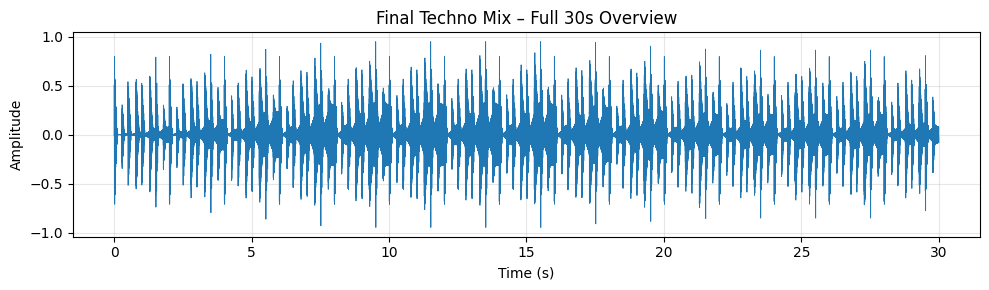

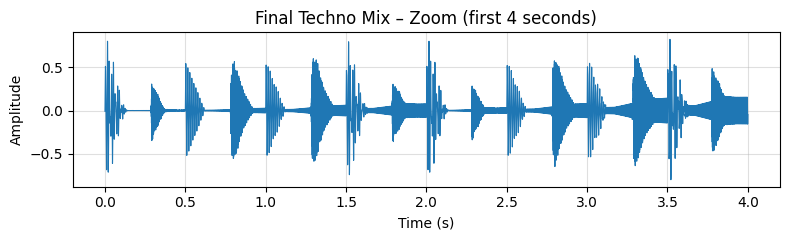

✅ 30-second techno groove generated:
   • Path: output/sounds/final_techno_mix.wav
   • Duration: 30.0 s @ 44100 Hz
   • Features:
       - Swinged off-beats + humanization (≤9 ms)
       - Sidechain (pad & bass) driven by kick
       - Hi-hat with subtle reverb
       - Filtered breakdown (16–22 s), drop at 22 s
       - Progressive arrangement (intro / build / outro)
   • Plots saved: output/plots/final_mix_time_full.png, output/plots/final_mix_time_zoom.png


In [20]:
# --- Block #17 – 30s Techno Groove (arrangement + export + visualization) ---

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.utils import FS, normalize_audio, save_wav
from src.synth_utils import (
    db, apply_env, ducking_envelope_from_kick,
    simple_delay_reverb, lowpass_1pole, jitter_indices
)

# =========================
# Setup
# =========================
Path("output/sounds").mkdir(parents=True, exist_ok=True)
Path("output/plots").mkdir(parents=True, exist_ok=True)

fs = FS
duration_total = 30.0  # seconds
samples_total = int(duration_total * fs)

# Expect: kick_filt, hihat_filt, bass_filt, pad_filt already built upstream
kick_filt  = normalize_audio(kick_filt)
hihat_filt = normalize_audio(hihat_filt)
bass_filt  = normalize_audio(bass_filt)
pad_filt   = normalize_audio(pad_filt)

# =========================
# Groove & Song Structure
# =========================
bpm = 120.0
beat = 60.0 / bpm           # 0.5 s per beat
bar  = 4 * beat             # 2.0 s per bar

# Swing (moves every 2nd 8th-note slightly later)
swing_pct = 0.56  # 0.5 = straight; >0.5 = later off-beat (house/techno feel)
swing_shift = (swing_pct - 0.5) * beat  # positive = later off-beats

# Song sections (in seconds)
intro_s, build_s, break_s, drop_s, outro_s = 0.0, 8.0, 16.0, 22.0, 28.0

# =========================
# 1) Kick pattern (4/4 beat)
# =========================
kick_track = np.zeros(samples_total)
kick_pos = []
t_pos = 0.0
while t_pos < duration_total:
    idx = int(t_pos * fs)
    end = min(idx + len(kick_filt), samples_total)
    kick_track[idx:end] += kick_filt[:end - idx]
    kick_pos.append(idx)
    t_pos += beat

# =========================
# 2) Hi-hat (swing, humanization, reverb)
# =========================
hihat_track = np.zeros(samples_total)
hat_positions = []

# Place 8th-note hi-hats on off-beats with swing
t_pos = 0.0
while t_pos < duration_total:
    k = int(t_pos / beat)
    off = k * beat + beat / 2
    off_swung = off + swing_shift
    if 0 <= off_swung < duration_total:
        hat_positions.append(int(off_swung * fs))
    t_pos += beat

# Add small humanization (≤9 ms)
hat_positions = jitter_indices(np.array(hat_positions), max_jitter_ms=9, fs=fs)

for idx in hat_positions:
    end = min(idx + len(hihat_filt), samples_total)
    vel = db(np.random.uniform(-1.5, 1.5))  # ±1.5 dB variation
    h = hihat_filt[:end - idx] * vel
    hihat_track[idx:end] += h

# Subtle mono reverb
hihat_track = simple_delay_reverb(hihat_track, fs, delay_ms=75, feedback=0.22, mix=0.15)

# =========================
# 3) Bassline (syncopated, follows swing)
# =========================
bass_track = np.zeros(samples_total)
note_ms = 140
note_len = int(note_ms * fs / 1000)

# Pattern per bar (in beats): [0, 1.5 (swing), 2.5 (swing), 3]
bass_steps = np.array([0.0, 1.5, 2.5, 3.0]) * beat
bass_steps_swung = []
for s in bass_steps:
    if (s % beat) == beat / 2:  # off-beat → apply swing
        bass_steps_swung.append(s + swing_shift)
    else:
        bass_steps_swung.append(s)
bass_steps_swung = np.array(bass_steps_swung)

t_pos = 0.0
while t_pos < duration_total:
    for s in bass_steps_swung:
        pos_s = t_pos + s
        if 0 <= pos_s < duration_total:
            i0 = int(pos_s * fs)
            i1 = min(i0 + note_len, samples_total)
            env = np.linspace(1.0, 0.0, i1 - i0, endpoint=True)
            bass_track[i0:i1] += bass_filt[:i1 - i0] * env
    t_pos += bar

# =========================
# 4) Pad (arrangement + filter sweep)
# =========================
pad_track = np.tile(pad_filt, int(np.ceil(samples_total / len(pad_filt))))[:samples_total]
time = np.arange(samples_total) / fs
pad_env = np.ones_like(pad_track)

# Intro fade-in (0–8s)
pad_env *= np.clip((time - intro_s) / (build_s - intro_s + 1e-9), 0, 1)
# Break volume dip (16–22s)
pad_env *= 1.0 - 0.35 * np.clip((time - break_s) / (drop_s - break_s + 1e-9), 0, 1)
# Outro fade-out (28–30s)
pad_env *= 1.0 - 0.6 * np.clip((time - outro_s) / (duration_total - outro_s + 1e-9), 0, 1)

pad_track = apply_env(pad_track, pad_env)

# Low-pass sweep during the break (400 → 6000 Hz)
pad_break = np.copy(pad_track)
mask_break = (time >= break_s) & (time < drop_s)
if mask_break.any():
    idxs = np.where(mask_break)[0]
    sweep = np.linspace(400.0, 6000.0, len(idxs))
    pad_break_section = pad_track[idxs[0]:idxs[-1] + 1]
    chunks = 40
    chunk_len = max(1, len(pad_break_section) // chunks)
    out = np.zeros_like(pad_break_section)
    for c in range(chunks):
        a = c * chunk_len
        b = (c + 1) * chunk_len if c < chunks - 1 else len(pad_break_section)
        cutoff = sweep[a]
        out[a:b] = lowpass_1pole(pad_break_section[a:b], fs, cutoff)
    pad_break[idxs[0]:idxs[-1] + 1] = out
    pad_track = pad_break

# =========================
# 5) Sidechain ducking (kick → pad & bass)
# =========================
kick_positions = np.array(kick_pos)
duck_env = ducking_envelope_from_kick(duration_total, fs, kick_positions,
                                      duck_ms=110, hold_ms=60, rel_ms=200, depth_db=-8.5)
pad_track  = apply_env(pad_track, duck_env)
bass_track = apply_env(bass_track, duck_env**0.6)  # lighter ducking on bass

# =========================
# 6) Mixdown + Export
# =========================
mix = (1.00 * kick_track
       + 0.70 * hihat_track
       + 0.90 * bass_track
       + 0.60 * pad_track)
mix = normalize_audio(mix, peak=0.95)

# Export stems
save_wav("output/sounds/step6_kick_norm.wav",  normalize_audio(kick_track), fs)
save_wav("output/sounds/step6_hihat_norm.wav", normalize_audio(hihat_track), fs)
save_wav("output/sounds/step6_bass_norm.wav",  normalize_audio(bass_track), fs)
save_wav("output/sounds/step6_pad_norm.wav",   normalize_audio(pad_track),  fs)

# Export final mix
output_path = "output/sounds/final_techno_mix.wav"
save_wav(output_path, mix, fs)

# =========================
# 7) Visualization (Time domain)
# =========================
t = np.arange(len(mix)) / fs

# Full-length waveform
plt.figure(figsize=(10, 3))
plt.plot(t, mix, lw=0.6)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Final Techno Mix – Full 30s Overview")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plot_full = "output/plots/final_mix_time_full.png"
plt.savefig(plot_full, dpi=300)
plt.show()

# Zoom (first 4 seconds)
t_zoom = t[t < 4.0]
mix_zoom = mix[:len(t_zoom)]
plt.figure(figsize=(8, 2.5))
plt.plot(t_zoom, mix_zoom, lw=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Final Techno Mix – Zoom (first 4 seconds)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plot_zoom = "output/plots/final_mix_time_zoom.png"
plt.savefig(plot_zoom, dpi=300)
plt.show()

# =========================
# 8) Summary
# =========================
print("✅ 30-second techno groove generated:")
print(f"   • Path: {output_path}")
print(f"   • Duration: {duration_total:.1f} s @ {fs} Hz")
print("   • Features:")
print("       - Swinged off-beats + humanization (≤9 ms)")
print("       - Sidechain (pad & bass) driven by kick")
print("       - Hi-hat with subtle reverb")
print("       - Filtered breakdown (16–22 s), drop at 22 s")
print("       - Progressive arrangement (intro / build / outro)")
print(f"   • Plots saved: {plot_full}, {plot_zoom}")


## 5.5 Observations and reflections

* The **final mix** illustrates the combined use of:

  * Oscillators (signal generation)
  * ADSR (temporal shaping)
  * Filters (spectral shaping)
  * System combination (addition/modulation)
* Each sound demonstrates a key theoretical concept:

  * **Kick:** envelope-controlled amplitude modulation.
  * **Hi-hat:** noise + band-pass filtering → stochastic signal shaping.
  * **Bassline:** sawtooth + low-pass → harmonic control.
  * **Pad:** phase modification via cascaded all-pass filters → spatial effect.
* The result shows how **DSP fundamentals** can be directly applied to creative audio synthesis — bridging the gap between *signal theory* and *sound design*.

# 6. Discussion & Conclusions

In this final section, we reflect on the different components implemented throughout the project and how they connect to the theoretical content from the course.
The goal is to demonstrate understanding of **discrete-time signal processing** concepts and their application to **sound synthesis**.

---

## 6.1 Role of each component

*(lecture 1–4; hands-on “Sampling”, “Filtering”, “Fourier analysis”)*  

| Synthesizer Block              | Theoretical concept                                                                      | Observed effect on the sound                                                |
| ------------------------------ | ---------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| **Oscillator**                 | Discrete-time sinusoidal signal generation (sampling, aliasing, spectral representation) | Defines the fundamental frequency and harmonic structure (timbre base).     |
| **ADSR envelope**              | Amplitude modulation / windowing                                                         | Shapes the time-domain evolution (attack, sustain, release).                |
| **Filters**                    | Convolution, LTI system frequency response                                               | Alters the spectral envelope, adds “warmth”, removes or enhances harmonics. |
| **All-pass**                   | Phase response of LTI systems                                                            | Adds spatial or “rough” qualities without changing magnitude.               |
| **Combination (add/multiply)** | Linearity and modulation principles                                                      | Allows creation of richer, more complex sounds.                             |

Each component corresponds to a **core DSP concept** explored in lectures and *hands-on* exercises, demonstrating a practical understanding of how theoretical ideas translate into perceptual effects.

---

## 6.2 Insights and analysis

From experimentation and listening:

* **Waveform choice** determines the basic timbre.

  * Sawtooth and square → bright and rich.
  * Triangle and sine → soft and pure.
* **ADSR shape** controls articulation:

  * Short attack/decay → percussive sounds.
  * Long release → smoother, ambient effects.
* **Filter design** sculpts the spectral color.

  * Low-pass filters remove harshness.
  * High-pass or all-pass add clarity or spatiality.
* **Combination of systems** (addition, multiplication, cascade) illustrates the **superposition principle** and **system interconnections** from *lecture 4*. 

These findings connect the perceptual domain (how it sounds) to the analytical one (signal representations, impulse responses, spectra).



👉 *(Optionnel — Bloc code #18)* : affichage comparatif des spectres de plusieurs sons produits pour illustrer ces différences (FFT ou spectrogrammes).

---



## 6.3 Limitations and improvements

While functional, this simplified synthesizer has some limitations:

* No **real-time processing** or **user control**.
* Basic **linear filtering**; no non-linear effects (e.g. distortion, saturation).
* ADSR and modulation shapes are static.
* No implementation of **frequency modulation (FM)** or **additive synthesis** beyond simple sums.

Possible extensions:

* Implement real-time control (via sliders or MIDI input).
* Explore FM synthesis and ring modulation.
* Add delay, reverb, or chorus using cascades of all-pass and feedback filters *(related to lecture 4 – feedback systems)*. 
* Build a small GUI to interactively modify ADSR or filter parameters.

---

## 6.4 Conclusion

This project demonstrated how a complete **digital sound synthesizer** can be built using fundamental concepts from the course:

* **Sinusoids** as basic signal components (Fourier representation).
* **Amplitude envelopes (ADSR)** to control dynamics (modulation).
* **Filters** as linear systems modifying frequency response (convolution).
* **System combination** to create complex sounds from simple building blocks.

By connecting implementation with theoretical principles, the notebook shows a clear understanding of the **relationship between mathematical signal models and audible perception** — turning DSP theory into creative sound design.

